## PROCESSING

In [13]:
# %%capture
# %pip install python-dotenv rtree pygeos pandas geopandas matplotlib lxml scipy

In [14]:
import os
import rtree
# import pygeos
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from shapely import wkt
# gpd.options.use_pygeos = True

from dotenv import load_dotenv
from dotenv import dotenv_values
import matplotlib
from bs4 import BeautifulSoup
import lxml
import json
import requests
import scipy


In [15]:
# Property parcel polygons
url_parcels = "https://opendata.vancouver.ca/explore/dataset/property-parcel-polygons/download/?format=geojson&timezone=Europe/Berlin&lang=en"
url_blocks = "https://maps.vancouver.ca/server/rest/services/Hosted/lsCityBlockArea/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
# Property tax report:
url_2020_2020="https://opendata.vancouver.ca/explore/dataset/property-tax-report/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
url_2016_2019="https://opendata.vancouver.ca/explore/dataset/property-tax-report-2016-2019/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
url_2011_2015="https://opendata.vancouver.ca/explore/dataset/property-tax-report-2011-2015/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
url_2006_2010="https://opendata.vancouver.ca/explore/dataset/property-tax-report-2006-2010/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"

# Census:
url_2006="https://geoweb.dnv.org/Products/Data/CSV/Cen2006Master_csv.zip"
url_2011="https://geoweb.dnv.org/Products/Data/CSV/Cen2011Master_csv.zip"
url_2016="https://geoweb.dnv.org/Products/Data/CSV/Cen2016Master_csv.zip"

url_median_incomes="https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1110023901&latestN=0&startDate=20050101&endDate=20200101&csvLocale=en&selectedMembers=%5B%5B21%5D%2C%5B1%5D%2C%5B1%5D%2C%5B1%5D%2C%5B%5D%5D&checkedLevels=4D1"
url_median_rents="https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=MetropolitanMajorArea&GeographyId=2410&CategoryLevel1=Primary%20Rental%20Market&CategoryLevel2=Summary%20Statistics&RowField=TIMESERIES"
url_house_price_benchmark="https://services5.arcgis.com/yhL5dRej97QO0Sj3/arcgis/rest/services/REBGV_Report/FeatureServer/0/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&groupByFieldsForStatistics=date&orderByFields=date%20asc&outStatistics=%5B%7B%22statisticType%22%3A%22avg%22%2C%22onStatisticField%22%3A%22Benchmark___residential%22%2C%22outStatisticFieldName%22%3A%22value%22%7D%5D&resultType=standard&cacheHint=true"
# From https://esrica-marketing.maps.arcgis.com/apps/opsdashboard/index.html#/34b57a07ad874c009f280fdd3b6e4610
# Ref https://vancouver.ca/home-property-development/zoning-and-land-use-policies-document-library.aspx

In [48]:
# Cleaning and writing out income data
incomes = pd.read_csv(url_median_incomes)
incomes = incomes[incomes['Statistics']=='Median income (excluding zeros)'][['REF_DATE','VALUE']]\
  .rename(columns={'REF_DATE':'year','VALUE':'median_income'})
incomes=incomes[incomes['year']>=2006]
incomes = pd.concat([incomes, pd.DataFrame([{'year': 2021},{'year': 2022}])], ignore_index=True)\
  .interpolate(method='spline', order=1, s=0.5)
incomes['median_income'] = incomes['median_income'].astype(int)

incomes.to_json('src/data/median_incomes.json', orient='records')
incomes

,year,median_income
0,2006,31500
1,2007,32600
2,2008,31600
3,2009,32000
4,2010,30400
5,2011,32700
6,2012,33200
7,2013,33200
8,2014,34200
9,2015,34100


In [17]:
# Make rents table from the statistical data, using only median values from year after and including 2006
rents = pd.read_html(url_median_rents, attrs={"class": "CawdDataTable"})[0]\
  .iloc[:, [0, 7]]\
  .rename(columns={"Unnamed: 0": "year", "Median Rent ($)": "rent_median"})
# Transform the tax coordinate to the Float
rents['rent_median']=rents['rent_median'].astype(int)
# Transform the year to the datetime
rents['year']=rents['year'].str.split(' ', expand=True).iloc[:, 0].astype(int)
# Filter the data to the year after and including 2006
rents=rents[rents['year']>=2006]
rents = pd.concat([rents, pd.DataFrame([{'year': 2022}])], ignore_index=True)\
  .interpolate(method='spline', order=1, s=0.5)
rents['rent_median'] = rents['rent_median'].astype(int)
rents

,year,rent_median
0,2006,815
1,2007,845
2,2008,880
3,2009,900
4,2010,930
5,2011,950
6,2012,975
7,2013,1000
8,2014,1035
9,2015,1073


In [18]:
rents.to_json('src/data/rents_historical.json', orient='records')

In [19]:
# Make prices table from the statistical data, using only average values from year after and including 2006
prices = pd.DataFrame(json.loads(requests.get(url_house_price_benchmark).text)['features'])['attributes']\
  .apply(pd.Series)\
  .rename(columns={"value": "price_median", "date": "year"})
prices = prices[prices['year'].str.endswith('10')]
prices['year'] = prices['year'].str.replace('_','')
prices['year'] = prices['year'].str.slice(0,4).astype(int)
prices = prices.loc[prices.year>=2006]
prices = pd.concat([prices, pd.DataFrame([{'year': 2022}])], ignore_index=True)\
  .interpolate(method='spline', order=1, s=0.5)
prices

/Users/hermanmitish/opt/miniconda3/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,price_median,year
0,4.814864e+05,2006
1,5.347409e+05,2007
2,5.220364e+05,2008
3,5.246818e+05,2009
4,5.373682e+05,2010
5,5.720864e+05,2011
6,5.721955e+05,2012
7,5.733318e+05,2013
8,6.050136e+05,2014
9,6.959909e+05,2015


In [20]:
prices.to_json('src/data/prices_historical.json', orient='records')

In [21]:
rents.set_index(['year'],inplace=True)
prices.set_index(['year'],inplace=True)

In [52]:
# parcels = gpd.read_file(url_parcels)[['tax_coord','geometry']]

# # Calculate the area of each parcel
# parcels['area'] = parcels['geometry'].to_crs(epsg=3857).area
# # Setting parcel centroid as a geometry
# parcels['geometry'] = parcels.to_crs(epsg=3857).centroid.to_crs(epsg=4326)
# # Transform the tax coordinate to the Float
# parcels['tax_coord']=parcels['tax_coord'].astype(float)
# parcels.set_index('tax_coord', inplace=True)
# parcels.to_file('src/data/parcels.geojson', driver='GeoJSON')

In [23]:
parcels = gpd.read_file('src/data/parcels.geojson')

In [24]:
# selection = ['LAND_COORDINATE','ZONING_DISTRICT','CURRENT_LAND_VALUE','CURRENT_IMPROVEMENT_VALUE','REPORT_YEAR']
# df = pd.read_csv(url_2020_2020, sep=";")[selection]

# df = pd.concat([ 
#   pd.read_csv(url_2016_2019, sep=";")[selection],
#   df
# ])

# df = pd.concat([ 
#   pd.read_csv(url_2011_2015, sep=";")[selection],
#   df
# ])

# df = pd.concat([ 
#   pd.read_csv(url_2006_2010, sep=";")[selection],  
#   df
# ])

# df.columns = [x.lower() for x in df.columns]
# # Aggregate property taxe values (find medium values) by the land coordinate, report year and zone category
# # Should it be Sum or Median?
# df = df.\
#   groupby(['land_coordinate','report_year','zoning_district'])\
#   [['current_improvement_value','current_land_value']].sum().reset_index()

# # Merge aggregated property taxes by the tax coordinate (land coordinate)
# df = df.merge(parcels, how='left', left_on='land_coordinate', right_on='tax_coord')
# df.to_csv('src/data/property_tax.csv', index=False)


In [25]:
df = pd.read_csv('src/data/property_tax.csv')
df

,land_coordinate,report_year,zoning_district,current_improvement_value,current_land_value,geometry,area
0,1963206,2006,RS-1,191000.0,2694000.0,POINT (-123.22286857639021 49.27488185534233),8509.732837
1,1963206,2007,RS-1,192000.0,3904000.0,POINT (-123.22286857639021 49.27488185534233),8509.732837
2,1963206,2008,RS-1,171000.0,4837000.0,POINT (-123.22286857639021 49.27488185534233),8509.732837
3,1963206,2009,RS-1,171000.0,4837000.0,POINT (-123.22286857639021 49.27488185534233),8509.732837
4,1963206,2010,RS-1,208000.0,4837000.0,POINT (-123.22286857639021 49.27488185534233),8509.732837
...,...,...,...,...,...,...,...
1676861,84531342,2018,CD-1 (567),0.0,50000.0,POINT (-123.03196926362222 49.20312908638018),8256.394121
1676862,84531342,2019,CD-1 (567),0.0,100000.0,POINT (-123.03196926362222 49.20312908638018),8256.394121
1676863,84531342,2020,CD-1 (567),0.0,100000.0,POINT (-123.03196926362222 49.20312908638018),8256.394121
1676864,84531342,2021,CD-1 (567),0.0,100000.0,POINT (-123.03196926362222 49.20312908638018),8256.394121


In [26]:

# Filter out rows where tax coordinate is absent
df = df.loc[~df.land_coordinate.isnull()]
# Filter out rows where land value is less or equal then 2 
# (in the original dataset many records have land value either 1 or 2, which probably has some special meaning)
df = df.loc[df.current_land_value>2]
# Filter out rows where improvement value is less or equal then 2 
# (in the original dataset many records have improvement value either 1 or 2, which probably has some special meaning)
df = df.loc[df.current_improvement_value>2]
# Filter out rows where land value is absent
df = df.loc[~df.current_land_value.isnull()]
# Filter out rows where improvement value is absent
df = df.loc[~df.current_improvement_value.isnull()]
# Get the selection of only the columns that we will use in further calculations
df = df[['area','current_land_value','current_improvement_value','zoning_district','land_coordinate', 'report_year', 'geometry']]


In [27]:
# Filter out the rows where zone category is 'Commercial','Industrial','Light Industrial','Limited Agriculture', 
# to get only the residential properties (or where zoning district starts with 'RR', 'RS', 'RT', 'RM', 'FM')
# df = df[~df['zone_category'].isin(['Commercial','Industrial','Light Industrial','Limited Agriculture'])]
df = df[
  (df['zoning_district'].str.startswith('RS'))| 
  (df['zoning_district'].str.startswith('RT'))| 
  (df['zoning_district'].str.startswith('RM'))| 
  (df['zoning_district'].str.startswith('FM'))| 
  (df['zoning_district'].str.startswith('RR'))]
# Filter out rows where area is less than 15 or more than 10 000
df = df.loc[(df.area>15) & (df.area<10000)]
# Sort rows by the area
df.sort_values('area',ascending=True,inplace=True)
df

,area,current_land_value,current_improvement_value,zoning_district,land_coordinate,report_year,geometry
829068,18.366552,3067000.0,2872000.0,RM-4,64620697,2011,POINT (-123.08943045176193 49.26453581625502)
829047,18.366552,2824000.0,1480000.0,RM-4,64620697,2008,POINT (-123.08943045176193 49.26453581625502)
829054,18.366552,2824000.0,1480000.0,RM-4,64620697,2009,POINT (-123.08943045176193 49.26453581625502)
829061,18.366552,3067000.0,3150000.0,RM-4,64620697,2010,POINT (-123.08943045176193 49.26453581625502)
829075,18.366552,3067000.0,3001000.0,RM-4,64620697,2012,POINT (-123.08943045176193 49.26453581625502)
...,...,...,...,...,...,...,...
125509,9998.131378,9345000.0,611000.0,RS-1,14480204,2015,POINT (-123.13465592434126 49.22126465362465)
125508,9998.131378,8920000.0,636000.0,RS-1,14480204,2014,POINT (-123.13465592434126 49.22126465362465)
125507,9998.131378,8920000.0,661000.0,RS-1,14480204,2013,POINT (-123.13465592434126 49.22126465362465)
125503,9998.131378,6108000.0,527000.0,RS-1,14480204,2009,POINT (-123.13465592434126 49.22126465362465)


In [28]:
# Calculate total property value, by summing up current_land_value and current_improvement_value
df['property_value'] = df['current_land_value'] + df['current_improvement_value']
# Calculate total property per square meter
df['property_value_pm'] = df['property_value']/df['area']
# Filter out rows where property_value is higher than 20 000 000
df = df.loc[df.property_value<20000000]
df

,area,current_land_value,current_improvement_value,zoning_district,land_coordinate,report_year,geometry,property_value,property_value_pm
829068,18.366552,3067000.0,2872000.0,RM-4,64620697,2011,POINT (-123.08943045176193 49.26453581625502),5939000.0,323359.542452
829047,18.366552,2824000.0,1480000.0,RM-4,64620697,2008,POINT (-123.08943045176193 49.26453581625502),4304000.0,234339.025208
829054,18.366552,2824000.0,1480000.0,RM-4,64620697,2009,POINT (-123.08943045176193 49.26453581625502),4304000.0,234339.025208
829061,18.366552,3067000.0,3150000.0,RM-4,64620697,2010,POINT (-123.08943045176193 49.26453581625502),6217000.0,338495.752723
829075,18.366552,3067000.0,3001000.0,RM-4,64620697,2012,POINT (-123.08943045176193 49.26453581625502),6068000.0,330383.179592
...,...,...,...,...,...,...,...,...,...
125509,9998.131378,9345000.0,611000.0,RS-1,14480204,2015,POINT (-123.13465592434126 49.22126465362465),9956000.0,995.786075
125508,9998.131378,8920000.0,636000.0,RS-1,14480204,2014,POINT (-123.13465592434126 49.22126465362465),9556000.0,955.778599
125507,9998.131378,8920000.0,661000.0,RS-1,14480204,2013,POINT (-123.13465592434126 49.22126465362465),9581000.0,958.279066
125503,9998.131378,6108000.0,527000.0,RS-1,14480204,2009,POINT (-123.13465592434126 49.22126465362465),6635000.0,663.624006


<AxesSubplot: ylabel='Frequency'>

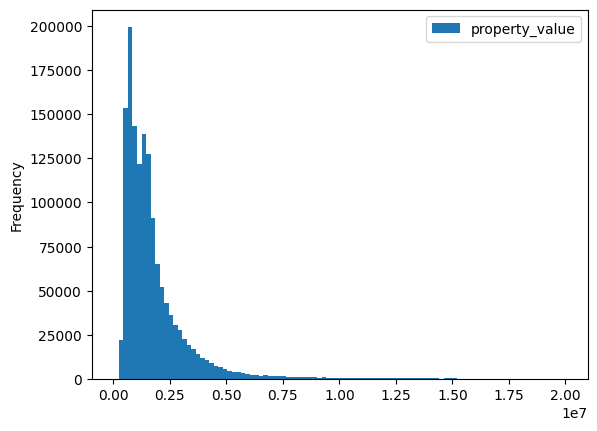

In [29]:
# Plot distribution of the property values. Most of the values fall within 50k and 250k
df[['property_value']].plot.hist(bins=100)

In [30]:
# Re-sort values by the property value
df = df.sort_values('property_value', ascending=True)
# Filter out values where property_value is less than 2000
df = df.loc[df.property_value>2000]
df.reset_index(inplace=True,drop=True)

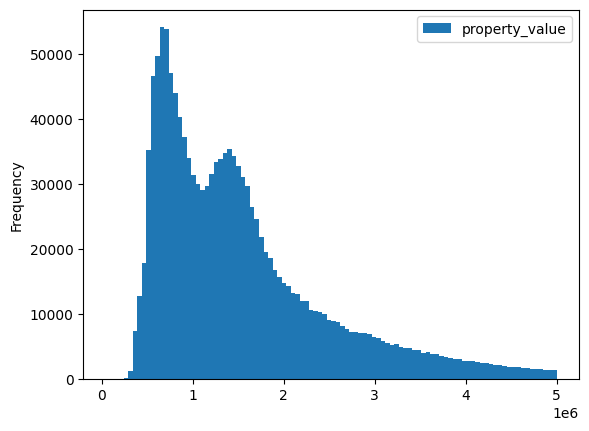

In [31]:
# Plot distribution of the property values under 5 000 000.
ax = df[['property_value']].loc[df.property_value<5000000].plot.hist(bins=100)

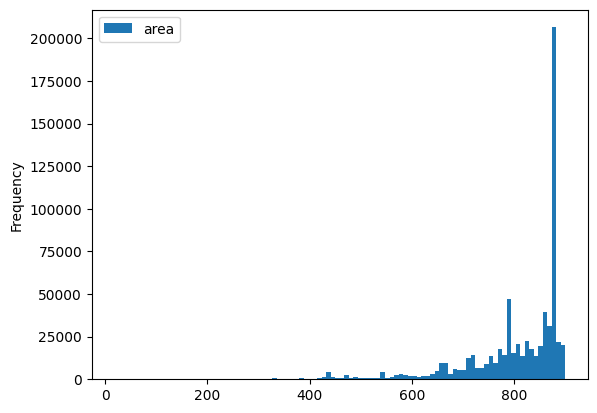

In [32]:
# Plot distribution of the parcel areas, where area is less than 900 sq.m.
ax = df[['area']].loc[df.property_value<5000000].loc[df.area<900].plot.hist(bins=100)

In [33]:
# Get the maximum and minimum values for rent and for sale from the Zillow for 2021
ref = {
    "price_high": 33990000,
    "price_low": 278000,
    "rent_high": 15000,
    "rent_low": 950,
    "year": 2021
}

In [34]:
# Make a common table for prices and rents, merging two tables by the year
prices_by_year = rents.merge(prices, left_index=True, right_index=True)

# Calculate synthetic [max,min] range and delta between them of the rent and sale prices, multiplying average price
# by the ratio between lowest price on Zillow for 2021 year and average price in Statistical data for the year 2020 
# (ideally it should have been both from the year 2020, but in Zillow we weren't able to take earlier value)
prices_by_year['rent_low'] = prices_by_year['rent_median']*ref['rent_low']/prices_by_year['rent_median'][2021]
prices_by_year['rent_high'] = prices_by_year['rent_median']*ref['rent_high']/prices_by_year['rent_median'][2021]
prices_by_year['rent_diff'] = prices_by_year['rent_high']-prices_by_year['rent_low']
prices_by_year['price_low'] = prices_by_year['price_median']*ref['price_low']/prices_by_year['price_median'][2021]
prices_by_year['price_high'] = prices_by_year['price_median']*ref['price_high']/prices_by_year['price_median'][2021]
prices_by_year['price_diff'] = prices_by_year['price_high']-prices_by_year['price_low']
prices_by_year

,rent_median,price_median,rent_low,rent_high,rent_diff,price_low,price_high,price_diff
year,,,,,,,,
2006,815,4.814864e+05,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07
2007,845,5.347409e+05,544.237288,8593.220339,8048.983051,125475.814158,1.534145e+07,1.521597e+07
2008,880,5.220364e+05,566.779661,8949.152542,8382.372881,122494.719656,1.497696e+07,1.485447e+07
2009,900,5.246818e+05,579.661017,9152.542373,8572.881356,123115.469924,1.505286e+07,1.492974e+07
2010,930,5.373682e+05,598.983051,9457.627119,8858.644068,126092.298102,1.541682e+07,1.529073e+07
2011,950,5.720864e+05,611.864407,9661.016949,9049.152542,134238.845440,1.641287e+07,1.627863e+07
2012,975,5.721955e+05,627.966102,9915.254237,9287.288136,134264.443390,1.641600e+07,1.628174e+07
2013,1000,5.733318e+05,644.067797,10169.491525,9525.423729,134531.088694,1.644860e+07,1.631407e+07
2014,1035,6.050136e+05,666.610169,10525.423729,9858.813559,141965.159779,1.735754e+07,1.721557e+07


In [35]:
# Calculate min and delta (max-min) of the property value by the year
norm = pd.DataFrame()
norm['property_value_min'] = df.reset_index().groupby(['report_year']).min().property_value
norm['property_value_diff'] = df.reset_index().groupby(['report_year']).max().property_value - df.reset_index().groupby(['report_year']).min().property_value
norm['property_value_pm_diff'] = df.reset_index().groupby(['report_year']).max().property_value_pm - df.reset_index().groupby(['report_year']).min().property_value_pm
norm['property_value_pm_min'] = df.reset_index().groupby(['report_year']).min().property_value_pm
norm


,property_value_min,property_value_diff,property_value_pm_diff,property_value_pm_min
report_year,,,,
2006,44700.0,19518300.0,7.231063e+05,20.911236
2007,56300.0,19777100.0,8.698566e+05,21.023261
2008,58800.0,19887200.0,8.698557e+05,21.956798
2009,58800.0,19890200.0,8.698557e+05,21.956798
2010,116000.0,19808700.0,9.628102e+05,47.151141
2011,116200.0,19847202.0,9.903171e+05,45.843204
2012,116100.0,19881400.0,1.076016e+06,45.189235
2013,116200.0,19796000.0,3.511359e+05,45.908601
2014,116200.0,19815500.0,3.893586e+05,44.927648


In [36]:
# Merge these grouped by the year values with the main Property Tax Values table
df = df.merge(norm, left_on='report_year', right_index=True, how='left')
# Calculate normalized property values (and per sq.m. property values) 
# in a range [0,1], by substracting min property value in that year 
# from property value, and dividing it by the delta of that year
df['property_value_norm'] = (df.property_value-df.property_value_min)/df.property_value_diff
df['property_value_pm_norm'] = (df.property_value_pm-df.property_value_pm_min)/df.property_value_pm_diff

In [37]:
# Merge main table with the our aggregated statistics for rents and prices by the year
df = df.merge(prices_by_year, left_on='report_year', right_index=True, how='left')

In [38]:
df.set_index(['land_coordinate','report_year'])

area  current_land_value  \
land_coordinate report_year                                    
66525011        2006          878.583171             41900.0   
62011957        2006         2677.986083             49100.0   
                2007         2677.986083             49000.0   
                2009         2677.986083             51500.0   
                2008         2677.986083             51500.0   
...                                  ...                 ...   
60611895        2017         1887.871075          16191000.0   
                2017         1882.831485          16191000.0   
                2017         1890.022800          16191000.0   
                2017         1886.554359          16191000.0   
                2017          939.819647          16191000.0   

                             current_improvement_value zoning_district  \
land_coordinate report_year                                              
66525011        2006                            2800.0           RM-4N   
62011957        2006                            6900.0            RS-1   
                2007                            7300.0            RS-1   
                2009                            7300.0            RS-1   
                2008                            7300.0            RS-1   
...                                                ...             ...   
60611895        2017                         3807000.0           RM-5B   
                2017                         3807000.0           RM-5B   
                2017                         3807000.0           RM-5B   
                2017                         3807000.0           RM-5B   
                2017                         3807000.0           RM-5B   

                                                                   geometry  \
land_coordinate report_year                                                   
66525011        2006         POINT (-123.06917160929383 49.260718032501686)   
62011957        2006          POINT (-123.13664212292714 49.27659669250894)   
                2007          POINT (-123.13664212292714 49.27659669250894)   
                2009          POINT (-123.13664212292714 49.27659669250894)   
                2008          POINT (-123.13664212292714 49.27659669250894)   
...                                                                     ...   
60611895        2017          POINT (-123.12850348880575 49.28319476608492)   
                2017          POINT (-123.12811011205758 49.28294037899339)   
                2017           POINT (-123.12791342470109 49.2828131715533)   
                2017          POINT (-123.12830659735974 49.28306752066394)   
                2017         POINT (-123.12865075781568 49.283290237312634)   

                             property_value  property_value_pm  \
land_coordinate report_year                                      
66525011        2006                44700.0          50.877369   
62011957        2006                56000.0          20.911236   
                2007                56300.0          21.023261   
                2009                58800.0          21.956798   
                2008                58800.0          21.956798   
...                                     ...                ...   
60611895        2017             19998000.0       10592.884367   
                2017             19998000.0       10621.237299   
                2017             19998000.0       10580.824739   
                2017             19998000.0       10600.277646   
                2017             19998000.0       21278.550682   

                             property_value_min  property_value_diff  \
land_coordinate report_year                                            
66525011        2006                    44700.0           19518300.0   
62011957        2006                    44700.0           19518300.0   
                2007                    56300.0           1977710

<AxesSubplot: ylabel='Frequency'>

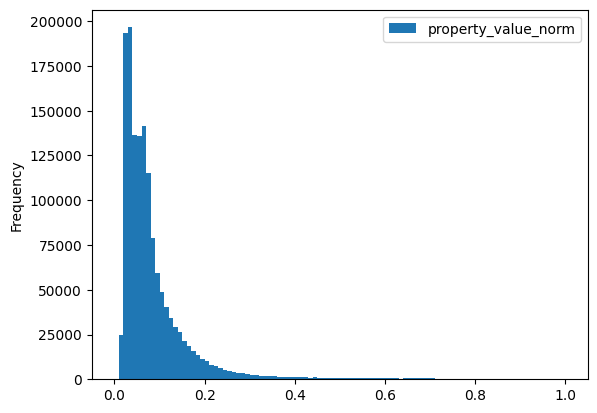

In [39]:
# Plot distribution of the normalized property values
df[['property_value_norm']].plot.hist(bins=100)

In [40]:
# Calculate synthetic rent and price by multiplying normalized property value 
# by the delta between min and max values in that year and adding the minimum value to it
df['rent'] = (df.property_value_norm*df.rent_diff) + df.rent_low
df['price'] = (df.property_value_norm*df.price_diff) + df.price_low
# Calculate synthetic rent and price for square meter by multiplying normalized property value per square meter
# by the delta between min and max values in that year and adding the minimum value to it
df['rent_pm'] = (df.property_value_pm_norm*df.rent_diff) + df.rent_low
df['price_pm'] = (df.property_value_pm_norm*df.price_diff) + df.price_low
df.sort_values('report_year')

,area,current_land_value,current_improvement_value,zoning_district,land_coordinate,report_year,geometry,property_value,property_value_pm,property_value_min,...,rent_low,rent_high,rent_diff,price_low,price_high,price_diff,rent,price,rent_pm,price_pm
0,878.583171,41900.0,2800.0,RM-4N,66525011,2006,POINT (-123.06917160929383 49.260718032501686),44700.0,50.877369,44700.0,...,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07,524.915254,1.129797e+05,525.236969,113547.513921
293947,1256.477275,477000.0,276000.0,RS-1,28179035,2006,POINT (-123.04927830562016 49.2235409325354),753000.0,599.294564,44700.0,...,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07,806.634921,6.101620e+05,531.124738,123938.319524
293959,1633.108804,733000.0,20100.0,RS-1,75814780,2006,POINT (-123.12917252916718 49.229990246016875),753100.0,461.145025,44700.0,...,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07,806.674695,6.102322e+05,529.641574,121320.814062
1384328,942.769294,2145000.0,3202000.0,RM-5A,11561394,2006,POINT (-123.13902514751358 49.28292101164552),5347000.0,5671.589048,44700.0,...,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07,2633.855234,3.834862e+06,585.580546,220042.574533
293965,2064.847324,695000.0,58100.0,RT-2,17074177,2006,POINT (-123.1167120107713 49.23578666869582),753100.0,364.724302,44700.0,...,524.915254,8288.135593,7763.220339,112979.748615,1.381360e+07,1.370062e+07,806.674695,6.102322e+05,528.606408,119493.940305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214751,1494.664136,2726000.0,45100.0,RS-1,82912134,2022,POINT (-123.14564579011422 49.20929713500471),2771100.0,1853.995110,146800.0,...,974.474576,15386.440678,14411.966102,322113.073805,3.938354e+07,3.906142e+07,2880.387772,5.487799e+06,1004.621454,403821.564596
1214764,936.190371,2677000.0,94400.0,RS-5,71405472,2022,POINT (-123.1737032166452 49.24775528242769),2771400.0,2960.295349,146800.0,...,974.474576,15386.440678,14411.966102,322113.073805,3.938354e+07,3.906142e+07,2880.605649,5.488389e+06,1023.286759,454411.011771
1214766,1814.413639,2729000.0,42500.0,RS-7,19471326,2022,POINT (-123.09859641881366 49.24691198129704),2771500.0,1527.490723,146800.0,...,974.474576,15386.440678,14411.966102,322113.073805,3.938354e+07,3.906142e+07,2880.678274,5.488586e+06,999.112729,388891.009673
1214772,990.678012,2700000.0,71600.0,RS-7,69117033,2022,POINT (-123.11410952012831 49.25611578553888),2771600.0,2797.679939,146800.0,...,974.474576,15386.440678,14411.966102,322113.073805,3.938354e+07,3.906142e+07,2880.750900,5.488783e+06,1020.543141,446974.853480


<AxesSubplot: ylabel='Frequency'>

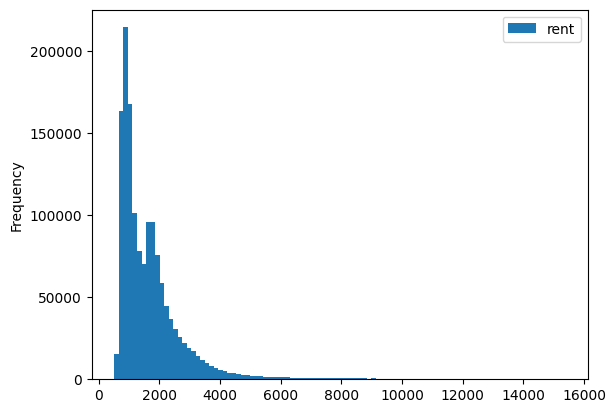

In [41]:
# Plot distribution of sythetic rents
df.sort_values(['rent'])[['rent']].plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

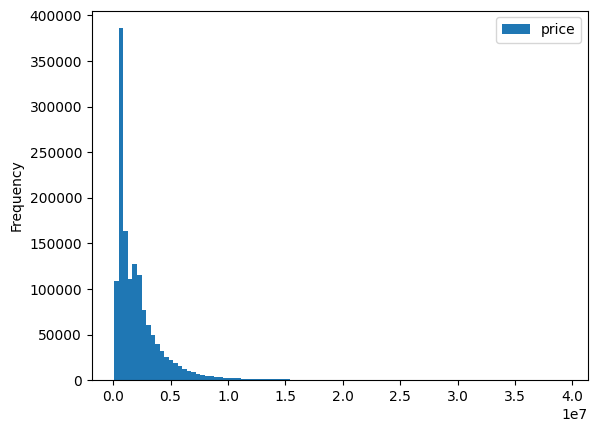

In [42]:
# Plot distribution of sythetic prices
df.sort_values(['price'])[['price']].plot.hist(bins=100)

In [43]:
# Filter out what is not going to be used on the map
df=df[['price','rent','price_pm','rent_pm','report_year', 'land_coordinate', 'geometry']]

## EXPORT

In [49]:
blocks = gpd.read_file(url_blocks)[['objectid', 'geometry']].rename(columns={'objectid':'id'})
blocks

,id,geometry
0,264593,"POLYGON ((-123.07563 49.24531, -123.07610 49.2..."
1,264594,"POLYGON ((-123.08082 49.23812, -123.08123 49.2..."
2,263069,"POLYGON ((-123.06264 49.25064, -123.06278 49.2..."
3,264595,"POLYGON ((-123.11540 49.23337, -123.11590 49.2..."
4,263070,"POLYGON ((-123.06617 49.26179, -123.06611 49.2..."
...,...,...
1995,261656,"POLYGON ((-123.14244 49.20556, -123.14295 49.2..."
1996,261657,"POLYGON ((-123.14364 49.20721, -123.14314 49.2..."
1997,261981,"POLYGON ((-123.17579 49.22750, -123.17552 49.2..."
1998,261658,"POLYGON ((-123.14243 49.20585, -123.14242 49.2..."


In [45]:

df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')
df

,price,rent,price_pm,rent_pm,report_year,land_coordinate,geometry
0,1.129797e+05,524.915254,1.135475e+05,525.236969,2006,66525011,POINT (-123.06917 49.26072)
1,1.209116e+05,529.409723,1.129797e+05,524.915254,2006,62011957,POINT (-123.13664 49.27660)
2,1.254758e+05,544.237288,1.254758e+05,544.237288,2007,62011957,POINT (-123.13664 49.27660)
3,1.231155e+05,579.661017,1.231155e+05,579.661017,2009,62011957,POINT (-123.13664 49.27660)
4,1.224947e+05,566.779661,1.224947e+05,566.779661,2008,62011957,POINT (-123.13664 49.27660)
...,...,...,...,...,...,...,...
1444042,2.816135e+07,12335.593220,6.991071e+05,975.175889,2017,60611895,POINT (-123.12850 49.28319)
1444043,2.816135e+07,12335.593220,7.003684e+05,975.697644,2017,60611895,POINT (-123.12811 49.28294)
1444044,2.816135e+07,12335.593220,6.985707e+05,974.953966,2017,60611895,POINT (-123.12791 49.28281)
1444045,2.816135e+07,12335.593220,6.994360e+05,975.311942,2017,60611895,POINT (-123.12831 49.28307)


In [46]:
# Merge parcel synthetic values with the property parcel geometries.
# Then aggregate data by the block - per year and by geometry. Get average values for price, price_pm, rent, rent_pm
df = df.sjoin(blocks, how='left', predicate='within')
df = df.groupby(['id','report_year']).mean(numeric_only=True).reset_index()
df['id']=df['id'].astype(int)
df = df[['report_year', 'id', 'price', 'rent']]

In [47]:
df.groupby('report_year')\
  .apply(lambda x: x[['id', 'price', 'rent']].to_dict('records'))\
  .to_json('src/data/blocks_data.json', orient='index')


In [53]:

# Setting parcel centroid as a geometry
blocks['geometry'] = blocks.to_crs(epsg=3857).centroid.to_crs(epsg=4326)
blocks.to_file('src/data/blocks.geojson', driver='GeoJSON')